In [1]:
#Code from Fabio to import index data including applying comp matrix - JT mods added
import os
import sys
import math
import numpy as np
import numpy.linalg
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import fcsparser

In [2]:
#Functions defined here

def get_inx(meta : dict):
    i = 1
    key = f'INDEX SORTING LOCATIONS_{i}'
    sort_locs = [] #Sort locations from the metadata, numerical row then column starting at 0
    while key in meta:
        sort_locs.append(meta[key])
        i += 1
        key = f'INDEX SORTING LOCATIONS_{i}'
    sort_locs = ''.join(sort_locs).split(';')
    return sort_locs

#Plate QC - check that cells are in the expected locations
#Inputs are directory containing files and name to apply to the output file and figure legend
#directory = '../Data/RN_PB/Indexed/'

def plate_qc(directory, data_name):
    #Count the number of plates
    count = 0
    for filename in os.listdir(directory):
        count += 1

    plotlen = int(math.ceil(count/2))  

    #Set up the plots
    fig, ax = plt.subplots(plotlen, 2, figsize = (16,(plotlen*5)))
    ax = ax.ravel()
    fig.subplots_adjust(hspace = 0.3, wspace=.3)

    count = -1

    xwell = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    ywell = [0,1,2,3,4,5,6,7,8,9,0,11,12,13,14,15]
    allwells = []

    for a in ywell: #this creates a list of all possible locations
        for b in xwell:
            allwells.append(str(a) + ','+ str(b))

    #Read in files and plot the data for each

    for filename in os.listdir(directory):
        fn = os.path.join(directory, filename)
        plateid = (fn.split('/'))[4]

        count += 1

        meta, data = fcsparser.parse(fn, reformat_meta=True)

        i = 1
        key = f'INDEX SORTING LOCATIONS_{i}'
        sort_locs = [] #Sort locations from the metadata, numerical row then column starting at 0
        while key in meta:
            sort_locs.append(meta[key])
            i += 1
            key = f'INDEX SORTING LOCATIONS_{i}'
        sort_locs = ''.join(sort_locs).split(';')

        for well in allwells:
            if well in sort_locs:  #if the well is in the list of wells with a sorted cell the colour will be darker
                alpha = 0.8
            else:
                alpha = 0.1        #plot empty wells in a lighter shade

            y, x = well.split(',')
            ax[count].scatter(x, y, alpha=alpha, color='gray')      
        ax[count].set_title(plateid)
        ax[count].invert_yaxis()  #flip the axis so the plate order looks natural
        ax[count].set_xticklabels(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24'])
        ax[count].set_yticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'])

    fig.suptitle(f'{data_name}', fontsize=14)    
    fig.savefig(f'../Results/Indexing/{data_name}_plot_by_plate.png',dpi=300)     
    
    return

def PBflowplot_byplate(sourcedata, gates, data_name):
#Function for plotting processed flow data by sourceplate (4 plates designated here)
#Currently set to colour 4th plate red (sorted for CD38 negative), can change # in col variable to swap to random colours
#3 inputs, sourcedata, gates, data_name
#sourcedata is the df containing the fcs data, possibly pre-compensated
#gates is the location of each gating line
#data_name is the name to be applied to legends and output files

    #Here's what's being plotted

    plot_list = [
        ['FSC-A', 'SSC-A'],
        ['FSC-A', 'FSC-W'],
        ['SSC-A', 'SSC-H'],
        ['Zombie', 'FSC-A'], 
        ['CD45-FITC', 'IgD-BB700'],
        ['CD66b-BV421', 'CD16-PE'],
        ['CD14-Pe-Cy5', 'CD16-PE'],
        ['Cd27-APC', 'IgD-BB700']
    ]
    
    #Define colour palette here, and make a new column for it 
    
    plates = sourcedata['Plate'].drop_duplicates().to_list() #15 plates, 5 x NE, 5 x Mono, 5 x nBC
    col = sns.color_palette('husl', n_colors = 3)
    cols = [col[0], col[0],col[0],col[0],col[0], col[1], col[1],col[1],col[1],col[1], col[2], col[2],col[2],col[2],col[2]] #can replace the colours used here
    palette = dict(zip(plates, cols))

    sourcedata['Colour'] = sourcedata['Plate'].map(palette)

    #Which fluorophores are on a log scale
    logs = ['CD16-PE', 'CD14-Pe-Cy5', 'CD56-PE-Cy7', 'CD66b-BV421', 'Zombie', 'CD45-FITC', 'Cd27-APC', 'R780/60-A', 'IgD-BB700']

    fig, axs = plt.subplots(4,2, figsize = (13,24))
    axs = axs.ravel()
    fig.subplots_adjust(hspace = 0.3, wspace=.3)

    for ax,y in zip(axs, plot_list):
        x_label = y[0]
        y_label = y[1]
        ax.scatter(sourcedata[x_label] + 11, sourcedata[y_label] + 11, alpha = 0.3, c = sourcedata['Colour'], s = 5)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
       #ax.legend()
        if x_label in logs:
            ax.set_xscale('log')
            ax.set_xlim(left = 10)
        if y_label in logs:
            ax.set_yscale('log')
            ax.set_ylim(bottom = 10)
        if x_label in gates:
            ax.axvline(gates[x_label], ls = '--', c = 'k')
        if y_label in gates:
            ax.axhline(gates[y_label], ls = '--', c = 'k')   
        
        ax.autoscale_view()  

    fig.suptitle(f'{data_name}', fontsize=16) 

    fig.savefig(f'../Results/Indexing/{data_name}_plot_by_plate.png',dpi=300) 
    
    #Assign cell type using defined gates

def PB_celltype_assign(data_in, gates_in, data_name):
#Takes 3 inputs, source df, gates dictionary, string containing name for data output
#Assume sort gates actually dumped dead, lin pos cells

    #Create boolean matrix based on gates in new columns

    #logs = ['CD16-PE', 'CD14-Pe-Cy5', 'CD56-PE-Cy7', 'CD66b-BV421', 'Zombie', 'CD45-FITC', 'Cd27-APC', 'R780/60-A', 'IgD-BB700']
    
    data_in['CD45_pos'] = data_in['CD45-FITC'] >= gates_in['CD45-FITC']
    data_in['IgD_pos'] = data_in['IgD-BB700'] >= gates_in['IgD-BB700']
    data_in['IgD_neg'] = data_in['IgD-BB700'] < gates_in['IgD-BB700']
    data_in['CD27_pos'] = data_in['Cd27-APC'] >= gates_in['Cd27-APC']
    data_in['CD27_neg'] = data_in['Cd27-APC'] < gates_in['Cd27-APC']
    data_in['CD66b_pos'] = data_in['CD66b-BV421'] >= gates_in['CD66b-BV421']
    data_in['CD66b_neg'] = data_in['CD66b-BV421'] < gates_in['CD66b-BV421']
    data_in['CD16_pos'] = data_in['CD16-PE'] >= gates_in['CD16-PE']
    data_in['CD16_neg'] = data_in['CD16-PE'] < gates_in['CD16-PE']
    data_in['CD14_pos'] = data_in['CD14-Pe-Cy5'] >= gates_in['CD14-Pe-Cy5']
    data_in['CD14_neg'] = data_in['CD14-Pe-Cy5'] < gates_in['CD14-Pe-Cy5']


    #Define each cell type - doing this explicitly to make code easier to follow. Tweaked to include IL1RAP neg for normal 38- cells

    nBC = ['CD45_pos','IgD_pos','CD27_neg']
    NE = ['CD45_pos','IgD_neg','CD66b_pos','CD16_pos']
    CD14pos_mono = ['CD45_pos','IgD_neg','CD66b_neg','CD16_pos','CD14_pos']
    CD14neg_mono = ['CD45_pos','IgD_neg','CD66b_neg','CD16_pos','CD14_neg']


    markers = [
        'CD45_pos' ,
        'IgD_pos' ,
        'IgD_neg' ,
        'CD27_pos' ,
        'CD66b_pos' ,
        'CD66b_neg' ,
        'CD16_pos' ,
        'CD14_pos' ,
        'CD14_neg' 
    ]

    col_names = ['nBC', 'NE', 'CD14pos_mono', 'CD14neg_mono']
    celltypes = ['nBC', 'NE', 'CD14pos_mono', 'CD14neg_mono']
    alltypes = [nBC, NE, CD14pos_mono, CD14neg_mono]

    #Store list of which columns are true for each cell type in a dictionary

    criteria = dict(zip(col_names, alltypes))


    #Use calculated criteria to add cell type true/false columns

    for x in col_names:
        data_in[x] = (data_in[criteria[x]] == True).all(axis = 1)

    data_in['unassigned'] = (data_in[col_names] == False).all(axis = 1)

    #Create a new column that contains the cell type

    col_names.append('unassigned')  #account for cells that were not assigned
    celltypes.append('unassigned')

    for a, b in zip(col_names, celltypes):

        data_in.loc[data_in[a] == True, 'celltype'] = b 

    #Define colour palette here, and make a new column for it

    ct = data_in['celltype'].drop_duplicates().to_list()
    col = sns.color_palette('husl', n_colors = len(ct))
    palette = dict(zip(ct, col))
    data_in['Colour'] = data_in['celltype'].map(palette)

    #Create a file containing assigned cell type for each well

    data_in.to_csv(f'../Data/{data_name}_index.tsv', sep = '\t')    #Save the big df to a file
    wellID = data_in[['Plate_Well', 'celltype']]
    wellID.to_csv(f'../Data/{data_name}_index_ID.tsv', sep = '\t')    #Save the well assignment to a file


    #Make a plot of cell type distributions

    fig, ax = plt.subplots()

    c = data_in['celltype'].value_counts().rename_axis('cell').reset_index(name='counts')
    ax = sns.barplot(x='cell', y='counts', data = c, palette = palette)

    fig.suptitle(f'{data_name}', fontsize=16)
    fig.savefig(f'../Results/Indexing/{data_name}_celltype_dist.png',dpi=300) 
    
    return data_in

def PBflowplot_bycelltype(sourcedata, gates, data_name):
#3 inputs, sourcedata, gates, data_name
#sourcedata is the df containing the fcs data, possibly pre-compensated
#gates is the location of each gating line
#data_name is the name to be applied to legends and output files

    #Here's what's being plotted

    plot_list = [
        ['FSC-A', 'SSC-A'],
        ['FSC-A', 'FSC-W'],
        ['SSC-A', 'SSC-H'],
        ['Zombie', 'FSC-A'], 
        ['CD45-FITC', 'IgD-BB700'],
        ['CD66b-BV421', 'CD16-PE'],
        ['CD14-Pe-Cy5', 'CD16-PE'],
        ['Cd27-APC', 'IgD-BB700']
    ]


    #Define colour palette here, and make a new column for it 

    ct = sourcedata['celltype'].drop_duplicates().to_list()
    col = sns.color_palette('husl', n_colors = len(ct))
    palette2 = dict(zip(ct, col))

    sourcedata['Colour'] = sourcedata['celltype'].map(palette2)


    #Which fluorophores are on a log scale
    logs = ['CD16-PE', 'CD14-Pe-Cy5', 'CD56-PE-Cy7', 'CD66b-BV421', 'Zombie', 'CD45-FITC', 'Cd27-APC', 'R780/60-A', 'IgD-BB700']


    fig, axs = plt.subplots(4,2, figsize = (13,24))
    axs = axs.ravel()
    fig.subplots_adjust(hspace = 0.3, wspace=.3)

    for ax,y in zip(axs, plot_list):
        x_label = y[0]
        y_label = y[1]
        ax.scatter(sourcedata[x_label] + 11, sourcedata[y_label] + 11, alpha = 0.3, c = sourcedata['Colour'], s = 5)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
       #ax.legend()
        if x_label in logs:
            ax.set_xscale('log')
            ax.set_xlim(left = 10)
        if y_label in logs:
            ax.set_yscale('log')
            ax.set_ylim(bottom = 10)
        if x_label in gates:
            ax.axvline(gates[x_label], ls = '--', c = 'k')
        if y_label in gates:
            ax.axhline(gates[y_label], ls = '--', c = 'k')   
        
        ax.autoscale_view()  

    fig.suptitle(f'{data_name}', fontsize=16)    
    fig.savefig(f'../Results/Indexing/{data_name}_plot_by_celltype.png',dpi=300) 

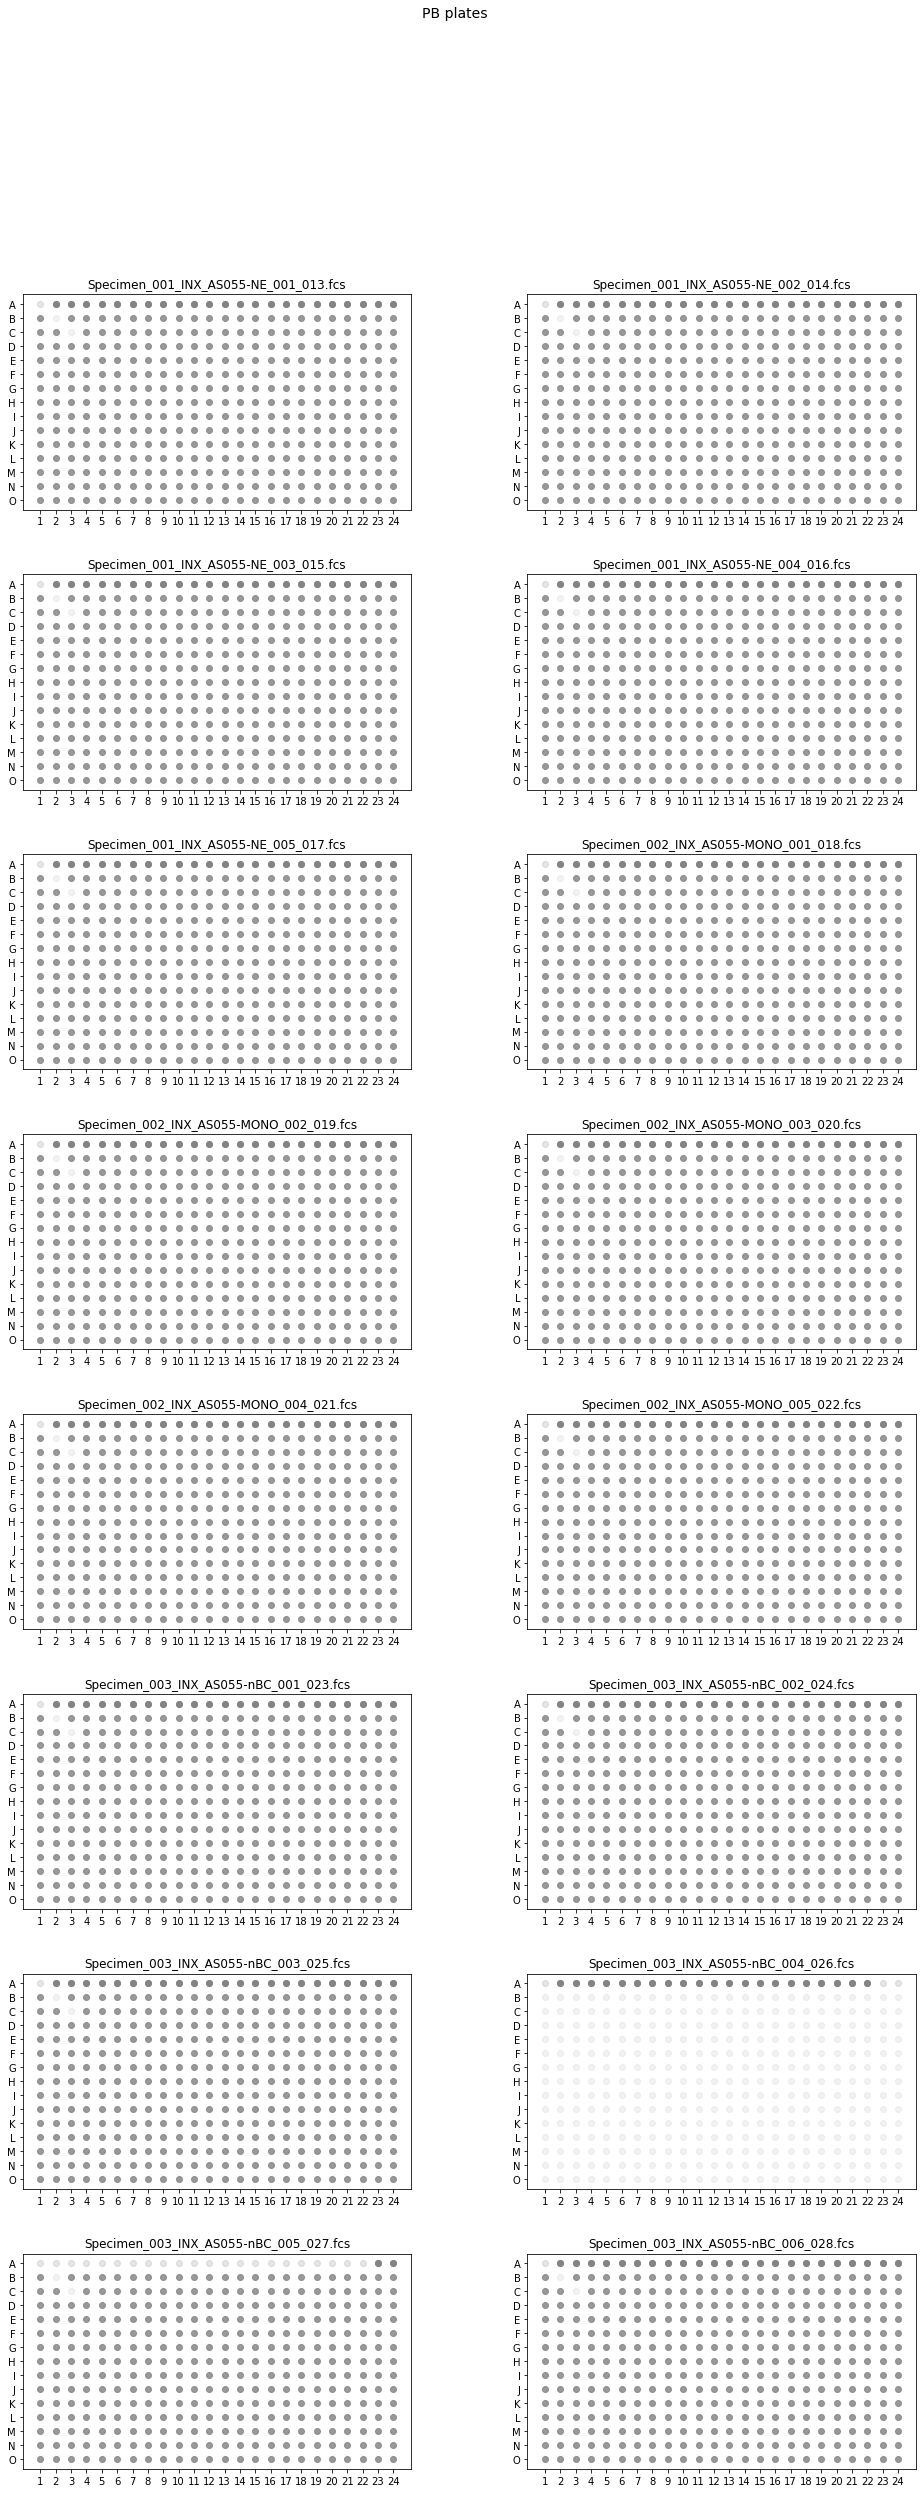

In [3]:
#run plate QC

directory = '../Data/RN_PB/Indexed/'
data_name = 'PB plates'

plate_qc(directory, data_name)

In [4]:
#retrieve file names
fileplates = []

for filename in os.listdir(directory):
    fn = os.path.join(directory, filename)
    plateid = (fn.split('/'))[4]
    fileplates.append(plateid)

In [5]:
#Create list of plate names for renaming and for iteration
#Note that one nBC plate has 2 index files associated - these are treated separaetly then the placeholder plate name replaced in the final df
ampplates = ['not_seq_NE1','AS-189','not_seq_NE3','not_seq_NE4','AS-195','not_seq_Mono1','AS-187','AS-193','not_seq_Mono4','not_seq_Mono5','not_seq_nBC1','not_seq_nBC2','AS-194','not_seq_nBC4a','not_seq_nBC4','AS-196']
#second list is missing the first plate name, use for iteration later
ampplates2 = ['AS-189','not_seq_NE3','not_seq_NE4','AS-195','not_seq_Mono1','AS-187','AS-193','not_seq_Mono4','not_seq_Mono5','not_seq_nBC1','not_seq_nBC2','AS-194','not_seq_nBC4a','not_seq_nBC4','AS-196']

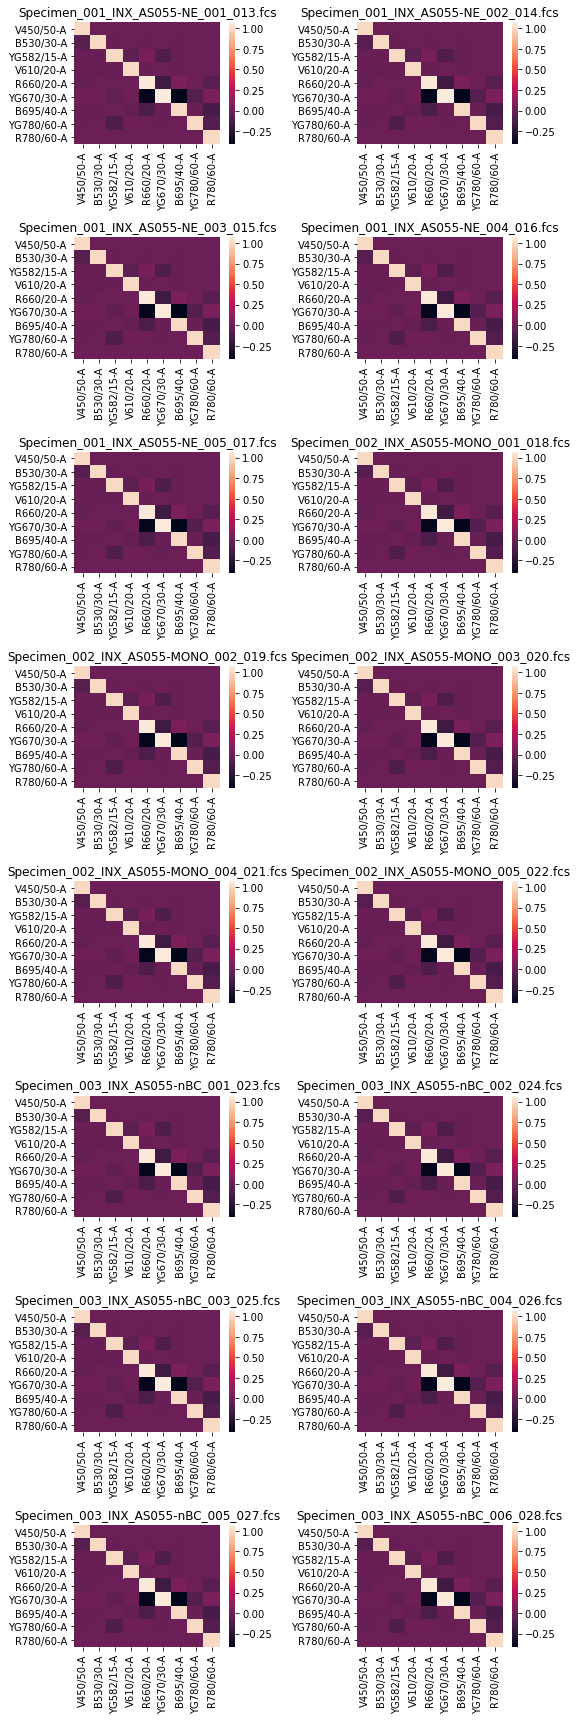

In [23]:
#Now read data into df and apply compensation, then output combined df with all rw or comp values

data_dict = {}
data_dict_comp = {}

plate_key = dict(zip(fileplates, ampplates))

#Set up column rename dictionary - these were compiled by pulling a single index file df into excel to check column labels
col_name = {
    'YG582/15-A':'CD16-PE',
    'YG670/30-A':'CD14-Pe-Cy5',
    'YG780/60-A':'CD56-PE-Cy7',
    'V450/50-A':'CD66b-BV421',
    'V610/20-A':'Zombie',
    'B530/30-A':'CD45-FITC',
    'R660/20-A':'Cd27-APC',
    'R780/60-A':'R780/60-A',
    'B695/40-A':'IgD-BB700'
}

#Count the number of plates
count = 0
for filename in os.listdir(directory):
    count += 1

plotlen = int(math.ceil(count/2))

#Set up comp plots
fig, ax = plt.subplots(plotlen, 2, figsize = (8,(plotlen*3)))
ax = ax.ravel()
fig.subplots_adjust(hspace = 0.3, wspace=.3)

count = -1

#Read in files and metadata

for filename in os.listdir(directory):
    fn = os.path.join(directory, filename)
    plateid = (fn.split('/'))[4]
    count += 1

    meta, data = fcsparser.parse(fn, reformat_meta=True)

    sort_locs = get_inx(meta)
    
    wells = []
    for loc in sort_locs:
        if loc == '':
            continue
        row_index, col = loc.split(',')
        col = str(int(col)+1)
        row = chr(65 + int(row_index)) #JT changed this to 65 from 64 - 65 is unicode for A, locations start at 0 (was 1 in test plate)
        well = row+col
        wells.append(well)   #Wells is a list of well locations with data derived from the index file
    
    # Get antibodies and rename with well names
    channel_idx = [int(x[2:-1]) for x in meta if x.startswith('$P') and x.endswith('S')]
    channeld = {meta['_channel_names_'][i-1]: meta[f'$P{i}S'] for i in channel_idx}

    data.index = pd.Index(wells, name='Sorted well') #Renames index with well name
    

    # Load compensation
    comp_fields = meta['SPILL'].split(',')
    n = int(comp_fields[0])
    channels = comp_fields[1: n+1]
    matrix = np.asarray(comp_fields[n+1:]).astype(np.float64).reshape((n, n)) 
    #matrix_pre = matrix.copy()   #Inversion actually does something
    matrix = numpy.linalg.inv(matrix)
    
    spill_matrix = pd.DataFrame(
        matrix,
        index=channels,
        columns=channels,
    )  #spill_matrix is the comp matrix
    
    #Plots compensation matrix
    # Reorder the dyes by wavelength
    wls = [int(x.split('/')[0][-3:]) for x in channels]
    idx = np.argsort(wls)
    spill_by_wls = spill_matrix.iloc[idx].T.iloc[idx].T

    ax[count] = sns.heatmap(spill_by_wls, ax=ax[count])
    ax[count].set_title(plateid)

    
    #Apply comp and replace column names with antibodies
    data_comp = data.copy()
    compensation = spill_matrix
    
    for channel in channels:
        data_comp[channel] = compensation.loc[:,channel].values @ data[channels].values.T #@ for matrix multiplication    
        
    #Store df and compdf for this iteration as a unique variable
    data_comp.rename(columns = channeld, inplace = True)
    data.rename(columns = channeld, inplace = True)
    
    plate = plate_key.get(filename) #pull the plate name for this file and use to label output dictionaries
    data['Well'] = data.index.get_level_values(0)
    data_comp['Well'] = data_comp.index.get_level_values(0)
    data['Plate'] = plate #add new column with plate name
    data_comp['Plate'] = plate  #add new column with plate name
    data_dict_comp[plate] = data_comp #output df into a dictionary
    data_dict[plate] = data  #output df into a dictionary      
  
fig.tight_layout()  
#plt.close() #comment out to view comp plots

#Rename columns that have channel and not fluorophore for raw and comp data - realised that not all files had the channel correctly named
for p in data_dict.keys():
    for c in col_name.keys():
        if c not in data_dict[p]:
            continue
            
        else:
            data_dict[p].rename(columns = {c:col_name[c]}, inplace = True)
            
for p in data_dict_comp.keys():
    for c in col_name.keys():
        if c not in data_dict_comp[p]:
            continue
            
        else:
            data_dict_comp[p].rename(columns = {c:col_name[c]}, inplace = True)            

#Combine all data or data_comp df into a single large df for gating
PB_alldata = data_dict['not_seq_NE1']
PB_alldata_comp = data_dict_comp['not_seq_NE1']

for p in ampplates2:
    PB_alldata = PB_alldata.append(data_dict[p], ignore_index=True)
    PB_alldata_comp = PB_alldata_comp.append(data_dict_comp[p], ignore_index=True)

#print((PB_alldata.shape[0])/15) #QC lines to check that there are 381 cells for each of 15 plates
#print(PB_alldata.shape[0]) 

#Need to rename ['Plate'] 'not_seq_nBC4a' to 'not_seq_nBC4' - this was the placeholder name given to the plate split over two inx files
PB_alldata['Plate'] = PB_alldata['Plate'].replace({'not_seq_nBC4a':'not_seq_nBC4'})
PB_alldata_comp['Plate'] = PB_alldata_comp['Plate'].replace({'not_seq_nBC4a':'not_seq_nBC4'})

#Add column to combine plate and well
PB_alldata['Plate_Well'] = PB_alldata['Plate'].astype(str) + '_' + PB_alldata['Well'].astype(str)
PB_alldata_comp['Plate_Well'] = PB_alldata_comp['Plate'].astype(str) + '_' + PB_alldata['Well'].astype(str)


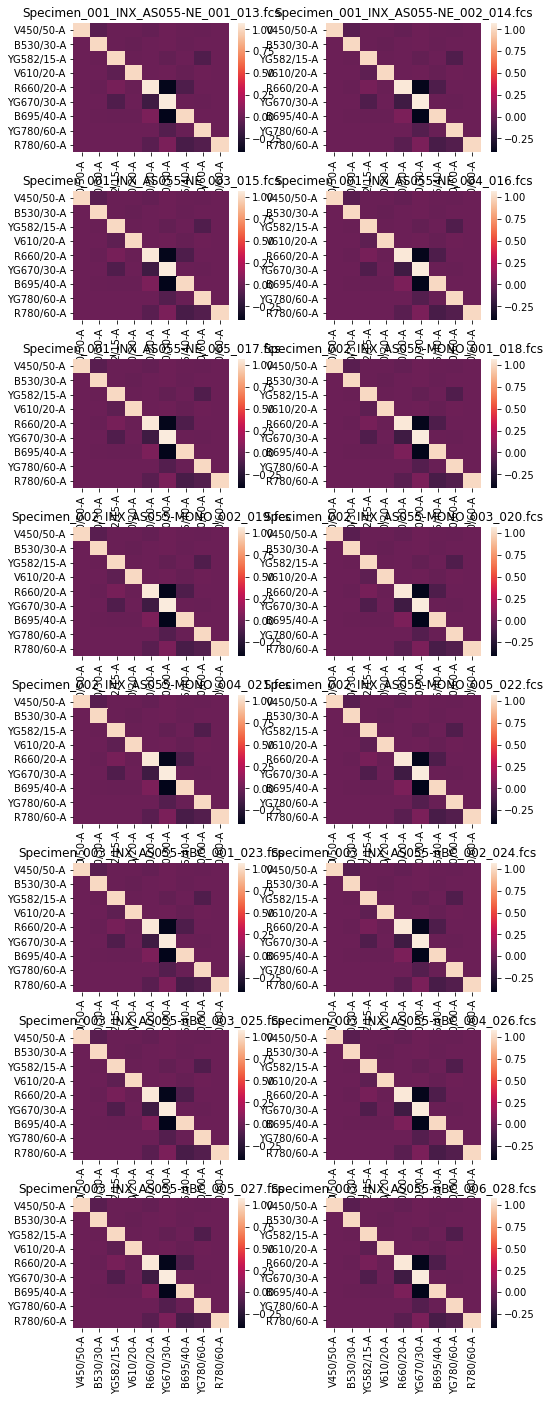

In [21]:
#Now read data into df and apply compensation, then output combined df with all rw or comp values
#Trying to trouble shoot compensation
data_dict = {}
data_dict_comp = {}

plate_key = dict(zip(fileplates, ampplates))

#Set up column rename dictionary - these were compiled by pulling a single index file df into excel to check column labels
col_name = {
    'YG582/15-A':'CD16-PE',
    'YG670/30-A':'CD14-Pe-Cy5',
    'YG780/60-A':'CD56-PE-Cy7',
    'V450/50-A':'CD66b-BV421',
    'V610/20-A':'Zombie',
    'B530/30-A':'CD45-FITC',
    'R660/20-A':'Cd27-APC',
    'R780/60-A':'R780/60-A',
    'B695/40-A':'IgD-BB700'
}

#Count the number of plates
count = 0
for filename in os.listdir(directory):
    count += 1

plotlen = int(math.ceil(count/2))

#Set up comp plots
fig, ax = plt.subplots(plotlen, 2, figsize = (8,(plotlen*3)))
ax = ax.ravel()
fig.subplots_adjust(hspace = 0.3, wspace=.3)

count = -1

#Read in files and metadata

for filename in os.listdir(directory):
    fn = os.path.join(directory, filename)
    plateid = (fn.split('/'))[4]
    count += 1

    meta, data = fcsparser.parse(fn, reformat_meta=True)

    sort_locs = get_inx(meta)
    
    wells = []
    for loc in sort_locs:
        if loc == '':
            continue
        row_index, col = loc.split(',')
        col = str(int(col)+1)
        row = chr(65 + int(row_index)) #JT changed this to 65 from 64 - 65 is unicode for A, locations start at 0 (was 1 in test plate)
        well = row+col
        wells.append(well)   #Wells is a list of well locations with data derived from the index file
    
    # Get antibodies and rename with well names
    channel_idx = [int(x[2:-1]) for x in meta if x.startswith('$P') and x.endswith('S')]
    channeld = {meta['_channel_names_'][i-1]: meta[f'$P{i}S'] for i in channel_idx}

    data.index = pd.Index(wells, name='Sorted well') #Renames index with well name
    

    # Load compensation
    comp_fields = meta['SPILL'].split(',')
    n = int(comp_fields[0])
    channels = comp_fields[1: n+1]
    matrix = np.asarray(comp_fields[n+1:]).astype(np.float64).reshape((n, n)) 
    #matrix_pre = matrix.copy()   #Inversion actually does something
    matrix = numpy.linalg.inv(matrix)
    matrix = matrix.T
    
    spill_matrix = pd.DataFrame(
        matrix,
        index=channels,
        columns=channels,
    )  #spill_matrix is the comp matrix
    
    #Plots compensation matrix
    # Reorder the dyes by wavelength
    wls = [int(x.split('/')[0][-3:]) for x in channels]
    idx = np.argsort(wls)
    spill_by_wls = spill_matrix.iloc[idx].T.iloc[idx].T

    ax[count] = sns.heatmap(spill_by_wls, ax=ax[count])
    ax[count].set_title(plateid)

    
    #Apply comp and replace column names with antibodies
    data_comp = data.copy()
    compensation = spill_matrix
    
    for channel in channels:
        data_comp[channel] = compensation.loc[:,channel].values @ data[channels].values.T #@ for matrix multiplication  
        
    #break    
    
#print(channels) 
#spill_matrix

In [10]:
print(matrix_pre)

[[1.00000000e+00 8.98311417e-02 5.94044733e-03 6.22234265e-03
  4.76760765e-02 4.68545447e-03 1.45903606e-03 0.00000000e+00
  4.60515730e-02]
 [3.42703480e-02 1.00000000e+00 8.23530764e-02 3.16253870e-03
  3.04323865e-04 0.00000000e+00 4.05388166e-01 3.13602686e-02
  3.82540977e-01]
 [9.93977974e-02 1.76108108e-02 1.00000000e+00 9.37924386e-03
  9.95801658e-04 0.00000000e+00 3.98296522e-03 8.49785006e-02
  9.08212890e-03]
 [7.87805655e-04 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 1.70869460e-03 0.00000000e+00
  0.00000000e+00]
 [2.32819391e-03 2.01445545e-03 5.61573763e-04 5.34743133e-03
  1.00000000e+00 1.87540626e-02 5.86551273e-03 0.00000000e+00
  1.19140229e-02]
 [5.11743076e-03 0.00000000e+00 0.00000000e+00 6.51042841e-02
  0.00000000e+00 1.00000000e+00 1.06126371e-02 0.00000000e+00
  1.59810102e-03]
 [2.51824617e-03 1.52522104e-01 1.16678643e-02 2.27951853e-02
  0.00000000e+00 0.00000000e+00 1.00000000e+00 5.92366724e-02
  4.68995417e-03]
 [0.00

In [115]:
plate_key

{'Specimen_001_INX_AS055-NE_001_013.fcs': 'not_seq_NE1',
 'Specimen_001_INX_AS055-NE_002_014.fcs': 'AS-189',
 'Specimen_001_INX_AS055-NE_003_015.fcs': 'not_seq_NE3',
 'Specimen_001_INX_AS055-NE_004_016.fcs': 'not_seq_NE4',
 'Specimen_001_INX_AS055-NE_005_017.fcs': 'AS-195',
 'Specimen_002_INX_AS055-MONO_001_018.fcs': 'not_seq_Mono1',
 'Specimen_002_INX_AS055-MONO_002_019.fcs': 'AS-187',
 'Specimen_002_INX_AS055-MONO_003_020.fcs': 'AS-193',
 'Specimen_002_INX_AS055-MONO_004_021.fcs': 'not_seq_Mono4',
 'Specimen_002_INX_AS055-MONO_005_022.fcs': 'not_seq_Mono5',
 'Specimen_003_INX_AS055-nBC_001_023.fcs': 'not_seq_nBC1',
 'Specimen_003_INX_AS055-nBC_002_024.fcs': 'not_seq_nBC2',
 'Specimen_003_INX_AS055-nBC_003_025.fcs': 'AS-194',
 'Specimen_003_INX_AS055-nBC_004_026.fcs': 'not_seq_nBC4a',
 'Specimen_003_INX_AS055-nBC_005_027.fcs': 'not_seq_nBC4',
 'Specimen_003_INX_AS055-nBC_006_028.fcs': 'AS-196'}

In [25]:
#Proposed gate locations
gate_loc = {
    'CD16-PE': 500,
    'CD14-Pe-Cy5': 5000 ,
    'CD56-PE-Cy7': 1000 ,
    'CD66b-BV421': 2500 ,
    'Zombie': 2500,
    'CD45-FITC': 1000,
    'Cd27-APC': 3000,
    'IgD-BB700': 3500,
    'R780/60-A':1000
}

gate_loc_comp = {
    'CD16-PE': 500,
    'CD14-Pe-Cy5': 5000 ,
    'CD56-PE-Cy7': 1000 ,
    'CD66b-BV421': 2500 ,
    'Zombie': 2500,
    'CD45-FITC': 1000,
    'Cd27-APC': 3000,
    'IgD-BB700': 3500,
    'R780/60-A':1000
}

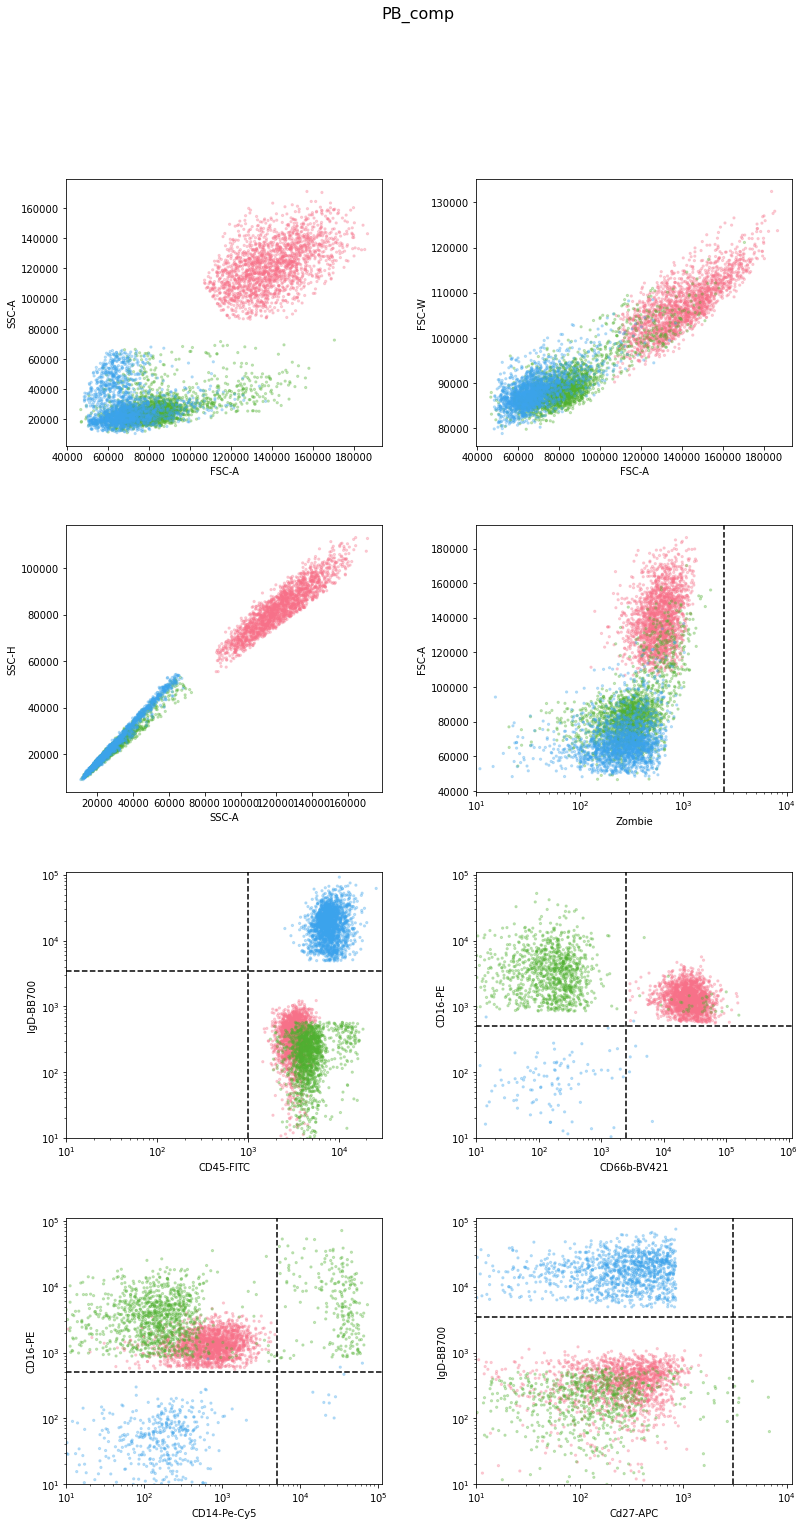

In [26]:
PBflowplot_byplate(PB_alldata_comp, gate_loc_comp, 'PB_comp')

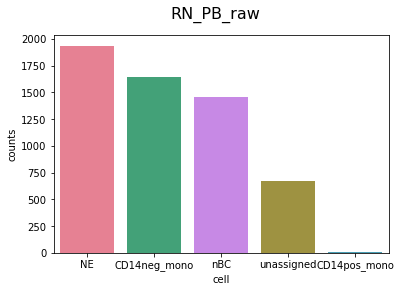

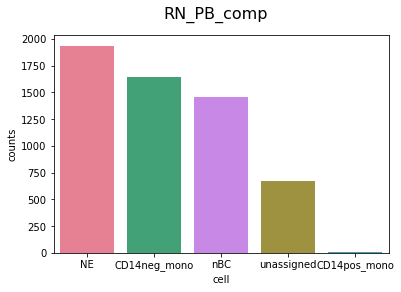

In [105]:
#Assign cell types and plot the distribution

PB_alldata_ct = PB_celltype_assign(PB_alldata, gate_loc, 'RN_PB_raw')
PB_alldata_comp_ct = PB_celltype_assign(PB_alldata_comp, gate_loc_comp, 'RN_PB_comp')

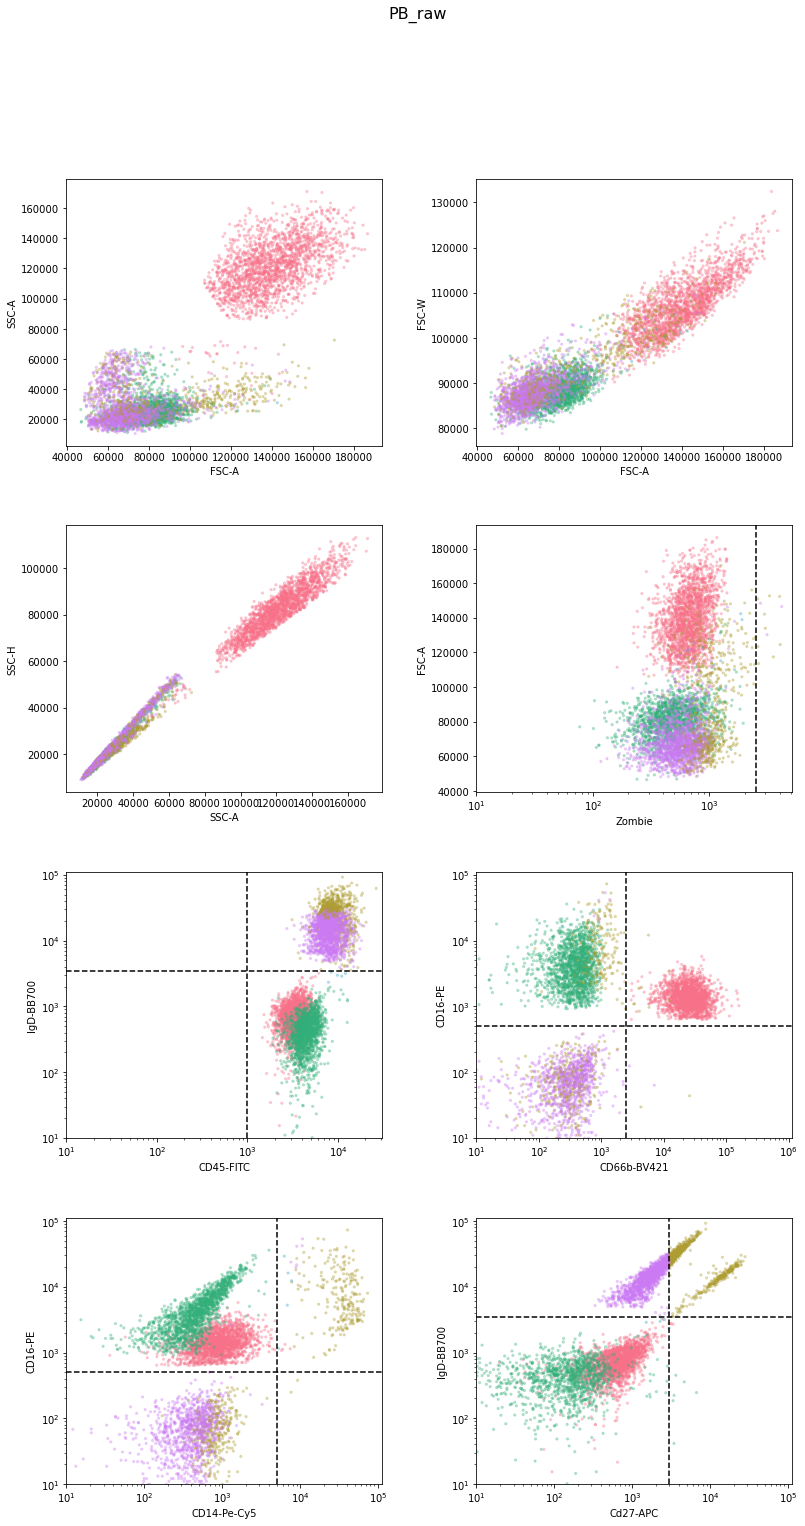

In [107]:
PBflowplot_bycelltype(PB_alldata_ct, gate_loc, 'PB_raw')